In [2]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torchvision.datasets import CIFAR10
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torchvision
import torchvision.utils as vutils
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.animation as animation
from IPython.display import HTML
torch.manual_seed(0) # set up random seed for reproducibility
torch.use_deterministic_algorithms(True) # This is needed for reproducible results

## Inputs
Inputs needed for this run
1. dataroot
2. workers
3. batch_size
4. image_size
5. beta1: beta1 for the Adam optimizer this number should be 0.5
6. number_epochs : number of epochs to train for
7. ngf: number of generator feature maps
8. ndf: number of discriminator feature maps
9. number of latent vector nz
10. Number of classes
11. nc: number of color chanels
12. number of Gpu's available ngpu
13. lr: learning rate for the generator and discriminator this number should be 0.0002

In [3]:
# Root directory for dataset
dataroot = "data/MNIST"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# number of classes
nclass = 10

**CIFAR10 DATASET**

Files already downloaded and verified


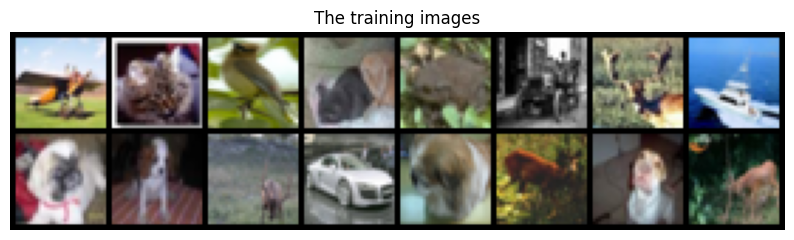

In [5]:
# This data set used is CIFAR10 which contains 3*32*32 images of 10 different classes.
# The data set is divided into 5000 training images and 1000 test images

dataloader = DataLoader(
    CIFAR10('data/CIFAR10',
            transform=transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]),
            download=True),
            batch_size=batch_size, shuffle=True, num_workers=workers)

# here we are setting up the device to run on gpu
device = torch.device("cuda:0" if torch.cuda.is_available() and ngpu>0 else "cpu")

# here we are plotting some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("The training images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

**LET'S SET OUR GENERATOR**

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Here we are creating the generator
netG = Generator().to(device)

# Printing the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


**SETTING UP OUR DISCRIMINATOR**

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Flatten()
        )

    def forward(self, input):
        return self.main(input).view(-1)

In [9]:
# Here we are creating the generator
netD = Discriminator().to(device)

# Printing the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
)


**LET'S SETUP OUR LOSS FUNCTION AND OPTIMIZER**

In [10]:
# Here we are initializing the ``BCELoss`` function
criterion = nn.BCEWithLogitsLoss()

#  Here is the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Here we are establishing convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Here we are Setting up Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**LET'S START THE TRAINING**

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/391]	Loss_D: 1.4590	Loss_G: 1.4044	D(x): -0.0850	D(G(z)): -0.0115 / -1.1045
[0/5][50/391]	Loss_D: 0.1842	Loss_G: 5.6097	D(x): 2.8211	D(G(z)): -2.4211 / -5.6056
[0/5][100/391]	Loss_D: 0.5692	Loss_G: 4.5827	D(x): 2.6793	D(G(z)): -0.9286 / -4.5701
[0/5][150/391]	Loss_D: 0.2576	Loss_G: 5.2985	D(x): 3.1284	D(G(z)): -1.9840 / -5.2924
[0/5][200/391]	Loss_D: 0.5043	Loss_G: 4.8276	D(x): 2.3996	D(G(z)): -1.0908 / -4.8149
[0/5][250/391]	Loss_D: 1.4664	Loss_G: 0.9300	D(x): -0.9389	D(G(z)): -4.5933 / -0.2192
[0/5][300/391]	Loss_D: 0.3896	Loss_G: 3.3338	D(x): 1.8526	D(G(z)): -2.0191 / -3.2866
[0/5][350/391]	Loss_D: 0.5354	Loss_G: 3.4047	D(x): 0.9279	D(G(z)): -4.0915 / -3.3295
[1/5][0/391]	Loss_D: 0.6500	Loss_G: 4.8792	D(x): 2.6499	D(G(z)): -0.7201 / -4.8678
[1/5][50/391]	Loss_D: 0.3077	Loss_G: 3.9225	D(x): 1.8325	D(G(z)): -3.2713 / -3.8901
[1/5][100/391]	Loss_D: 0.5155	Loss_G: 4.2889	D(x): 2.2708	D(G(z)): -1.2007 / -4.2651
[1/5][150/391]	Loss_D: 0.7552	Loss_G: 7.468

**LET'S VISUALIZE OUR TRAINING LOOP**

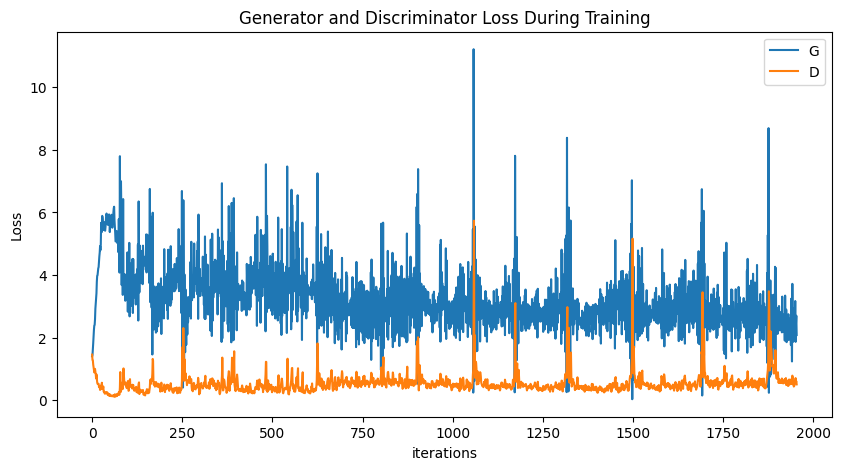

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**LE'S VISUALIZE OUR G'S PROGRESSION**

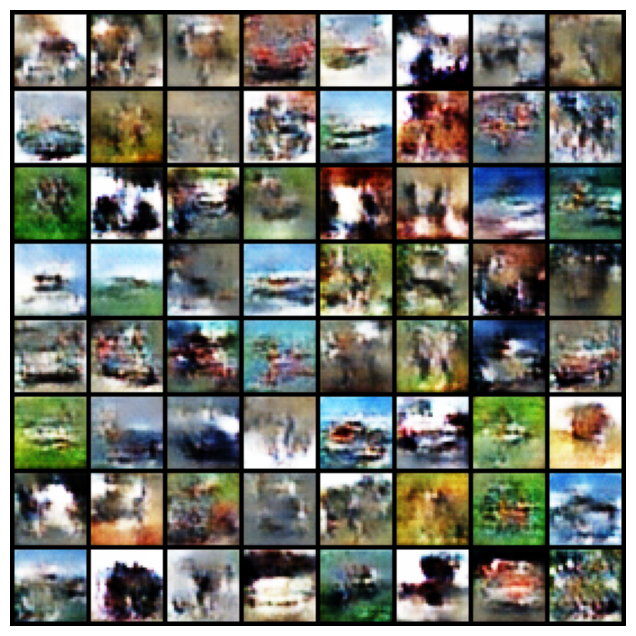

In [13]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())